## Loading Necessary Packages

In [3]:
import os
import re
import glob
import numpy as np
import pandas as pd
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import Augmentor

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Rescaling, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, RandomFlip, \
RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Training and Test data set path

In [3]:
train_dir = "Skin cancer ISIC The International Skin Imaging Collaboration/Train"
test_dir = "Skin cancer ISIC The International Skin Imaging Collaboration/Test"

## Image Generator to generate images in batches with a fixed image and width

In [5]:
# parameters fixed as per the use case
batch_size = 32
img_height = 180
img_width = 180
validation_split = 0.2

In [6]:
train_ds = image_dataset_from_directory(train_dir, validation_split=validation_split,
                             subset='training', image_size = (img_height, img_width),
                             batch_size = batch_size, label_mode='categorical', seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
val_ds = image_dataset_from_directory(train_dir, validation_split=validation_split,
                             subset='validation', image_size = (img_height, img_width),
                             batch_size = batch_size, label_mode='categorical', seed=123)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### Inference:
    1) Dataset has total of 2239 images of skin cancer types for training . 
    2) These iamges are divided into 9 sub-directories.
    3) Each subdirectory is the respective class to which the image belongs.

## Unique Categories for classification

In [13]:
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

## Visualize Class Distribution

In [40]:
original_df = pd.DataFrame()
for class_name in class_names:
    temp_df = pd.DataFrame({'Path':glob.glob(os.path.join(train_dir, class_name, '*.jpg')), 'Label':class_name})
    original_df = pd.concat([original_df, temp_df] , axis=0)

original_df['Label'].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

In [17]:
def plot_class_distribution(class_names, train_path):

    class_count={}
    
    for class_name in class_names:
        class_count[class_name]  = sum(pd.Series(train_path).str.lower().str.contains(class_name))

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    pd.Series(class_count).sort_values(ascending=False).plot(kind='bar')
    plt.title('Class Distribution', fontsize=16) 
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12, ha='right')
    plt.yticks(fontsize=12)
    
    plt.subplot(1, 2, 2)
    (round(pd.Series(class_count)/sum(pd.Series(class_count)),4)*100).sort_values(ascending=False).plot(kind='bar')
    plt.title('Class Distribution', fontsize=16) 
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.xticks(rotation=45, fontsize=12, ha='right')
    plt.yticks(fontsize=12)
    plt.tight_layout();

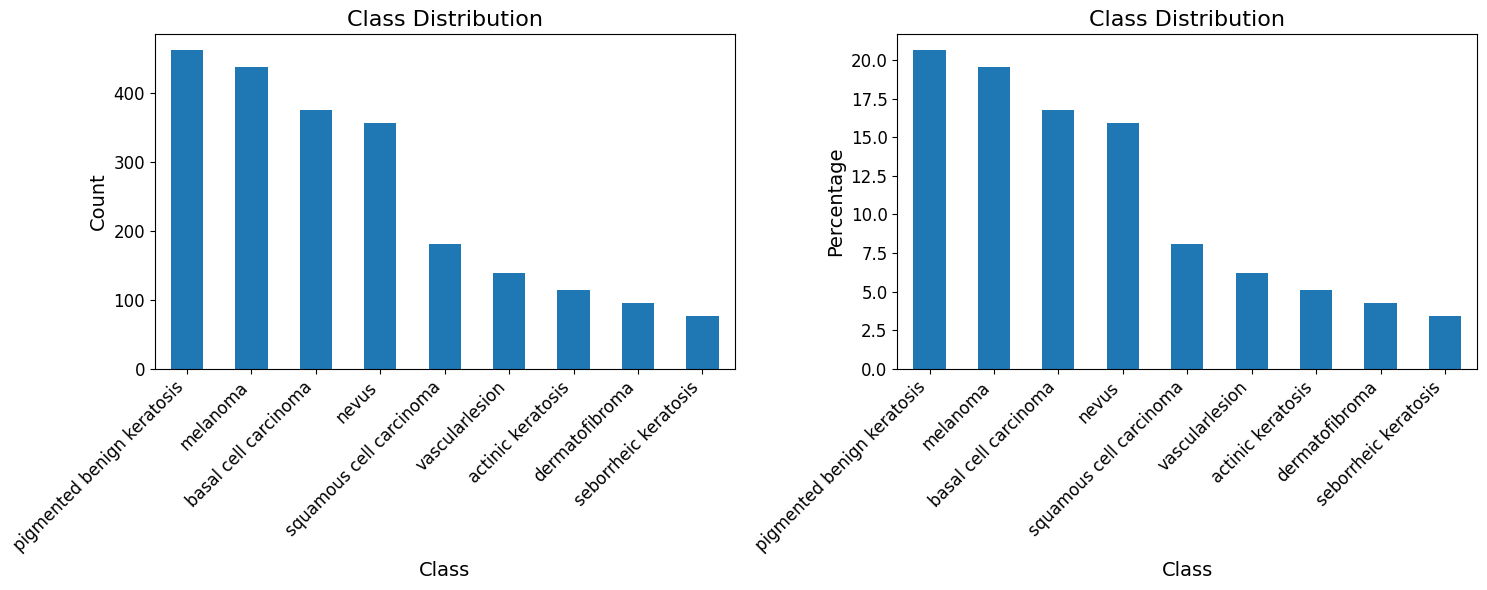

In [25]:
train_path = glob.glob(os.path.join(train_dir,'*/*.jpg'))
plot_class_distribution(class_names, train_path)

### Inference:
    1) 'Pigmented Benign Keratosis' has largest count with 462 images(~22% of training dataset) followed by melanoma
    2) 'Dermatofibroma' and 'Seborrheic Keratosis' have lowest count with 96 and 78 images respectively.

## Visualize one instance of each of the nine classes

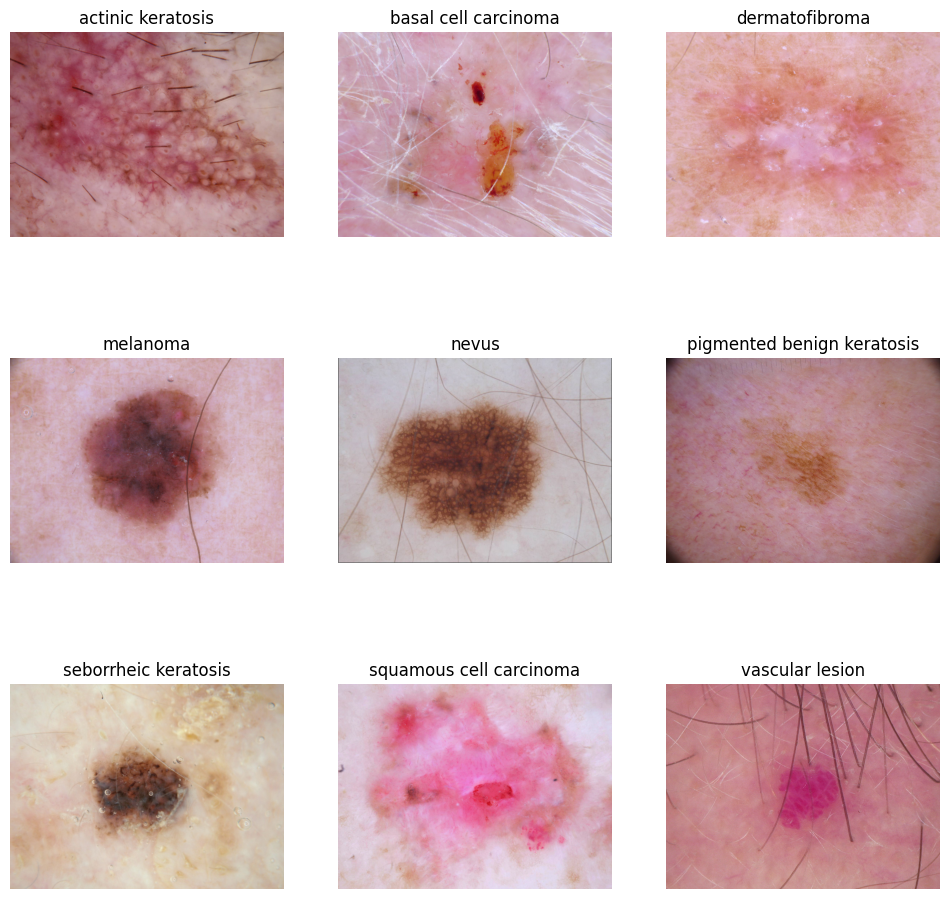

In [179]:
train_path_df = pd.Series(train_path)
plt.figure(figsize=(12, 12))
for i, class_name in enumerate(class_names):
    ax = plt.subplot(3, 3, i + 1)
    image_instance = train_path_df[train_path_df.str.lower().str.contains(class_name)].iloc[0]
    image = Image.open(image_instance)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")

In [82]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building

### Approach 1: Without any data augmentation

In [63]:
model = Sequential()

model.add(Rescaling(1./255,input_shape=(img_height,img_width,3)))   #Rescaling Layer

# first conv2d layer
model.add(Conv2D(16, padding='same', kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# second conv2d layer
model.add(Conv2D(32, padding='same', kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# third conv2d layer
model.add(Conv2D(64, padding='same', kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

#add softmax
model.add(Dense(len(class_names), activation='softmax'))

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Compile Model

In [53]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

### Train Model

In [65]:
%%time

model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 33s 182ms/step - accuracy: 0.2195 - loss: 2.0112 - val_accuracy: 0.4098 - val_loss: 1.5084
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 32s 189ms/step - accuracy: 0.4379 - loss: 1.4754 - val_accuracy: 0.5501 - val_loss: 1.2981
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 32s 190ms/step - accuracy: 0.5297 - loss: 1.2591 - val_accuracy: 0.5627 - val_loss: 1.1857
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 32s 186ms/step - accuracy: 0.6081 - loss: 1.0523 - val_accuracy: 0.6162 - val_loss: 1.0502
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 209ms/step - accuracy: 0.6654 - loss: 0.9039 - val_accuracy: 0.6526 - val_loss: 0.9409
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 216ms/step - accuracy: 0.7176 - loss: 0.7435 - val_accuracy: 0.7090 - val_loss: 0.7979
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 215ms/step - accuracy: 0.7667 - loss: 0.6365 - val_accuracy: 0.7461 - val_loss: 0.7430
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 209ms/step - accuracy: 0.8046 - loss: 0

### Plot Train/Validation Accuracy and Loss

In [58]:
def plot_curve(history, epochs):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(epochs)
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show();

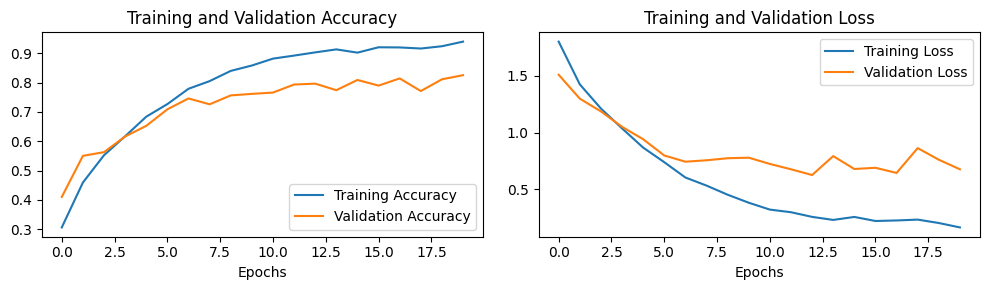

In [67]:
plot_curve(history, epochs)

### Inference:

    1) The model's training accuracy shows a steady increase of upto 94%, while validation accuracy increases upto ~82%.

    2) A high training accuracy suggests the model has effectively captured the noise within the data. 
       However, its poor performance on validation data indicates a lack of generalizability.

    3) These observations confirm the presence of overfitting. To address this issue, augmentation techniques will be employed. 
       Given the limited training data available, new samples will be generated by making slight modifications to existing data 
       (such as horizontal/vertical image flipping, minor image rotations, etc.), which will then be used for training the model.


## Image Augmentation

In [17]:
augmentation_data = Sequential([RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                RandomRotation(0.1), RandomZoom(0.1), RandomContrast(0.2)])

C:\Users\E009825\AppData\Local\anaconda3\envs\tensorflow\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Visualize after augmentation for one instance of training image

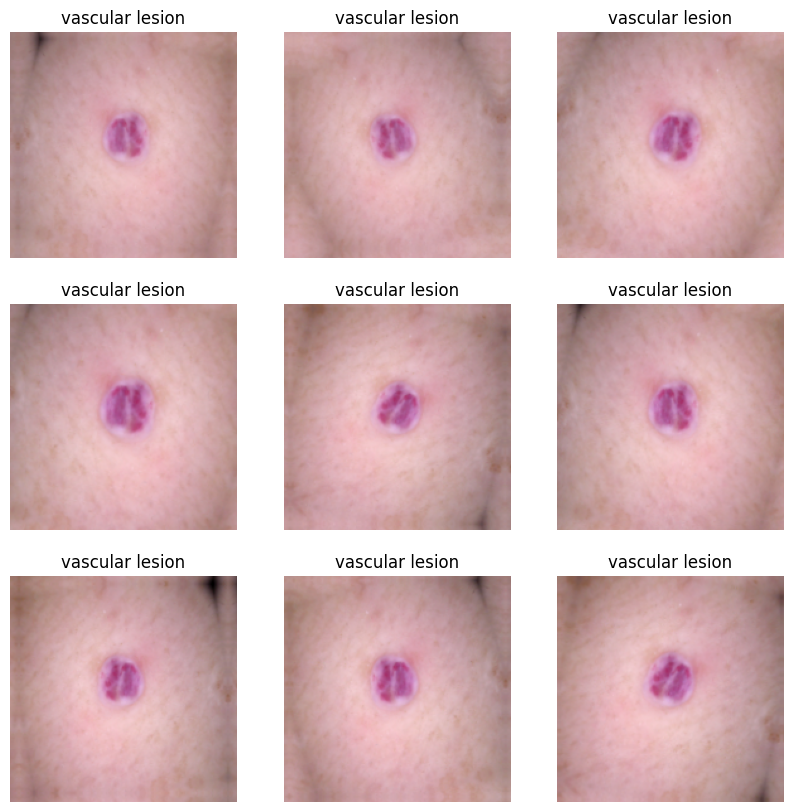

In [49]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        ax.imshow(augmented_images[0].numpy().astype("uint8"))
        ax.set_title(class_names[np.where(labels[0]==1)[0][0]])
        plt.axis("off")

### Approach 2: With Data Augmentation

#### To Control Overfitting, we will use 2 techniques:
    1) L2 regularization in each convolution layer with regularization rate = 0.001
    2) Use early stopping criteria to stop model training before overfitting and saving the best model

In [75]:
model_img_aug = Sequential()

model_img_aug.add(augmentation_data)
model_img_aug.add(Rescaling(1./255,input_shape=(img_height,img_width,3)))   #Rescaling Layer

# first conv2d layer
model_img_aug.add(Conv2D(16, padding='same', kernel_size = (3,3), activation = 'relu',kernel_regularizer=l2(0.001)))
model_img_aug.add(MaxPooling2D(pool_size = (2,2)))

# second conv2d layer
model_img_aug.add(Conv2D(32, padding='same', kernel_size = (3,3), activation = 'relu',kernel_regularizer=l2(0.001)))
model_img_aug.add(MaxPooling2D(pool_size = (2,2)))

# third conv2d layer
model_img_aug.add(Conv2D(64, padding='same', kernel_size = (3,3), activation = 'relu',kernel_regularizer=l2(0.001)))
model_img_aug.add(MaxPooling2D(pool_size = (2,2)))

# flatten and put a fully connected layer
model_img_aug.add(Flatten())
model_img_aug.add(Dense(128, activation='relu'))
model_img_aug.add(Dropout(0.1))

#add softmax
model_img_aug.add(Dense(len(class_names), activation='softmax'))

model_img_aug.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

#### Early Stopping and continuously monitoring validation loss

In [79]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    mode='min', 
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore the best model weights
)

model_checkpoint = ModelCheckpoint(
    'best_model_v6.h5',  # Filepath to save the best model
    monitor='val_loss',
    save_best_only=True,  # Save only the best model
    mode='min'  # Save the model with the lowest validation loss
)

In [79]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    mode='min', 
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore the best model weights)

model_checkpoint = ModelCheckpoint(
    'best_model_img_aug.h5',  # Filepath to save the best model
    monitor='val_loss',
    save_best_only=True,  # Save only the best model
    mode='min'  # Save the model with the lowest validation loss)

In [81]:
%%time
## Your code goes here, note: train your model for 20 epochs

model_img_aug.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 20
history = model_img_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.2372 - loss: 2.0847

169/169 ━━━━━━━━━━━━━━━━━━━━ 57s 315ms/step - accuracy: 0.2376 - loss: 2.0834 - val_accuracy: 0.4224 - val_loss: 1.5531
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.4446 - loss: 1.5170

169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 350ms/step - accuracy: 0.4446 - loss: 1.5168 - val_accuracy: 0.4937 - val_loss: 1.3970
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 57s 336ms/step - accuracy: 0.4758 - loss: 1.4293 - val_accuracy: 0.4699 - val_loss: 1.4151
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.5091 - loss: 1.3492

169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 290ms/step - accuracy: 0.5091 - loss: 1.3491 - val_accuracy: 0.5100 - val_loss: 1.3233
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5260 - loss: 1.2954

169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - accuracy: 0.5260 - loss: 1.2953 - val_accuracy: 0.5419 - val_loss: 1.2582
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - accuracy: 0.5419 - loss: 1.2385 - val_accuracy: 0.5264 - val_loss: 1.2583
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5624 - loss: 1.1842

169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 292ms/step - accuracy: 0.5624 - loss: 1.1842 - val_accuracy: 0.5702 - val_loss: 1.1591
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5872 - loss: 1.1355

169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 318ms/step - accuracy: 0.5871 - loss: 1.1356 - val_accuracy: 0.5820 - val_loss: 1.1158
Epoch 9/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.5864 - loss: 1.1031

169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 290ms/step - accuracy: 0.5864 - loss: 1.1030 - val_accuracy: 0.6132 - val_loss: 1.0687
Epoch 10/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.6094 - loss: 1.0494

169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 285ms/step - accuracy: 0.6094 - loss: 1.0494 - val_accuracy: 0.6318 - val_loss: 0.9806
Epoch 11/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 288ms/step - accuracy: 0.6134 - loss: 1.0376 - val_accuracy: 0.6303 - val_loss: 1.0200
Epoch 12/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 47s 278ms/step - accuracy: 0.6386 - loss: 0.9935 - val_accuracy: 0.6058 - val_loss: 1.0181
Epoch 13/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 294ms/step - accuracy: 0.6376 - loss: 0.9586 - val_accuracy: 0.6162 - val_loss: 1.0375
Epoch 14/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.6534 - loss: 0.9378

169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 283ms/step - accuracy: 0.6534 - loss: 0.9378 - val_accuracy: 0.6526 - val_loss: 0.9793
Epoch 15/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 280ms/step - accuracy: 0.6499 - loss: 0.9589 - val_accuracy: 0.6355 - val_loss: 0.9979
Epoch 16/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.6697 - loss: 0.8994

169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 302ms/step - accuracy: 0.6697 - loss: 0.8995 - val_accuracy: 0.6733 - val_loss: 0.8852
Epoch 17/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.6765 - loss: 0.8791

169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 290ms/step - accuracy: 0.6765 - loss: 0.8790 - val_accuracy: 0.7023 - val_loss: 0.8629
Epoch 18/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.6857 - loss: 0.8294

169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - accuracy: 0.6857 - loss: 0.8296 - val_accuracy: 0.7008 - val_loss: 0.8443
Epoch 19/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 284ms/step - accuracy: 0.7131 - loss: 0.7843 - val_accuracy: 0.6689 - val_loss: 0.8887
Epoch 20/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7005 - loss: 0.8162

169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 317ms/step - accuracy: 0.7005 - loss: 0.8164 - val_accuracy: 0.7030 - val_loss: 0.8338
CPU times: total: 1h 20min 50s
Wall time: 17min 4s


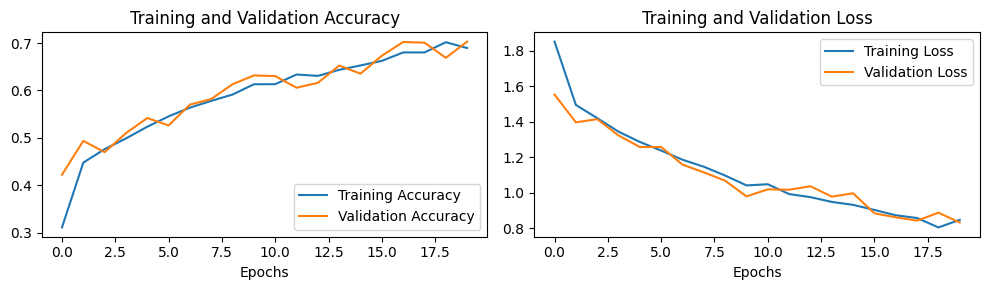

In [83]:
plot_curve(history, epochs)

### Inference:

    1) By leveraging augmented data, the difference between training and validation accuracy has been very much minimised.
       This indicated overfitting has been addressed to large extent.

    2) Both the training and validation accuracy increase almost at the same rate upto 70%.
    
    3) This model is now exhibiting more underfitting than overfitting.

    4) Hence, we will create enrich the training dataset by artifically creating 500 samples for each category using 
       'Augmentor' library.

## Augmentation Using Augmentor Library

In [45]:
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    p = Augmentor.Pipeline(class_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) # adding 500 samples per class more to reduce sparseness in classes.

Initialised with 114 image(s) found.
Output directory set to C:\Users\E009825\OneDrive - Cigniti Technologies Limited\Work\CNN\Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x234EF7FDC30>: 100%|█| 500/500 [00:10<00:00, 48.46 Sam


Initialised with 376 image(s) found.
Output directory set to C:\Users\E009825\OneDrive - Cigniti Technologies Limited\Work\CNN\Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x234EAD869B0>: 100%|█| 500/500 [00:11<00:00, 43.98 Sam


Initialised with 438 image(s) found.
Output directory set to C:\Users\E009825\OneDrive - Cigniti Technologies Limited\Work\CNN\Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x234EAD93070>: 100%|█| 500/500 [00:57<00:00,  8.64 Sa


Initialised with 357 image(s) found.
Output directory set to C:\Users\E009825\OneDrive - Cigniti Technologies Limited\Work\CNN\Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x234EB2A4850>: 100%|█| 500/500 [00:51<00:00,  9.76 Sam


Initialised with 462 image(s) found.
Output directory set to C:\Users\E009825\OneDrive - Cigniti Technologies Limited\Work\CNN\Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x234EB2A64D0>: 100%|████████████| 500/500 [00:10<00:00, 48.15 Samples/s]


Initialised with 77 image(s) found.
Output directory set to C:\Users\E009825\OneDrive - Cigniti Technologies Limited\Work\CNN\Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x234EF763670>: 100%|███████████| 500/500 [00:26<00:00, 18.82 Samples/s]


Initialised with 181 image(s) found.
Output directory set to C:\Users\E009825\OneDrive - Cigniti Technologies Limited\Work\CNN\Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x234E678EC80>: 100%|████████████| 500/500 [00:11<00:00, 44.90 Samples/s]


### Visualization of classes after augmentation

In [198]:
class_count={}
    
for class_name in class_names:

    total_class_count = len(glob.glob(f"{train_dir}/{class_name}/*.jpg")) + len(glob.glob(f"{train_dir}/{class_name}/output/*.jpg"))
    
    class_count[class_name]  = total_class_count

#### Total count of images before augmentation

In [79]:
len(glob.glob(f"{train_dir}/*/*.jpg")) 

2239

#### Total count of augmentated images added

In [81]:
len(glob.glob(f"{train_dir}/*/output/*.jpg"))

4500

#### Total count of training images after augmentation

In [23]:
len(glob.glob(f"{train_dir}/*/*.jpg")) + len(glob.glob(f"{train_dir}/*/output/*.jpg"))

6739

#### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
path_list_new = glob.glob(f"{train_dir}/*/output/*.jpg")
path_list_new[2000:2006]

['Skin cancer ISIC The International Skin Imaging Collaboration/Train\\nevus\\output\\nevus_original_ISIC_0000019.jpg_18556219-18ab-4b93-8a81-4ab650db063b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train\\nevus\\output\\nevus_original_ISIC_0000019.jpg_350e1767-82d3-43bc-b519-f4edb5f6827c.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train\\nevus\\output\\nevus_original_ISIC_0000019.jpg_7be6e230-9d44-45f1-8a17-744807125c77.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train\\nevus\\output\\nevus_original_ISIC_0000020.jpg_97d0ac70-7d89-4b9d-82bc-7e419be02eec.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train\\nevus\\output\\nevus_original_ISIC_0000021.jpg_490d66d8-751e-41c8-9791-1f587221a560.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train\\nevus\\output\\nevus_original_ISIC_0000023.jpg_b786e70f-35e5-42b4-bf70-46b0600ff5a1.jpg']

In [44]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(f"{train_dir}/*/output/*.jpg")]
lesion_list_new[0:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [46]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

#### View the augmented image paths and labels in a new df

In [48]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2.head()

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis


In [50]:
new_df = pd.concat([original_df, df2])
new_df.head()

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis


#### Inspecting the classes after adding 500 samples per label

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64 


Label
pigmented benign keratosis    0.142751
melanoma                      0.139190
basal cell carcinoma          0.129990
nevus                         0.127170
squamous cell carcinoma       0.101054
vascular lesion               0.094821
actinic keratosis             0.091111
dermatofibroma                0.088292
seborrheic keratosis          0.085621
Name: proportion, dtype: float64


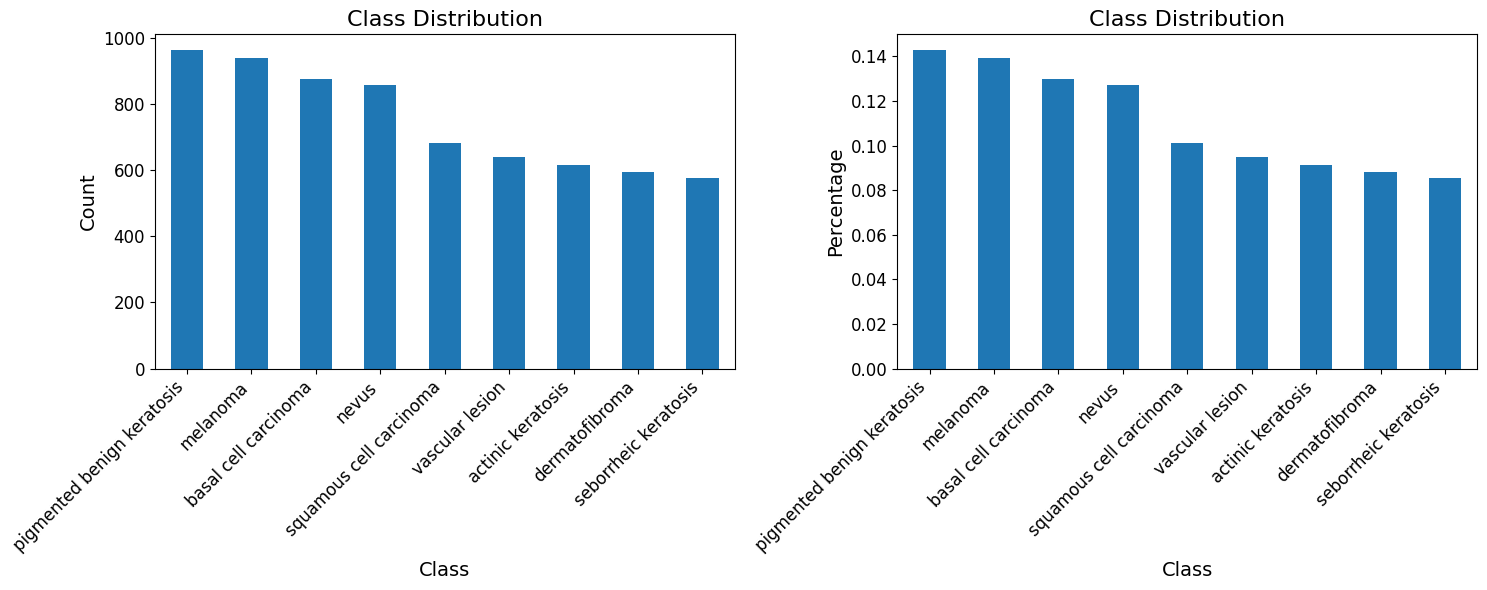

In [68]:
print(new_df['Label'].value_counts(),'\n\n')

print(new_df['Label'].value_counts(normalize=True))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)

new_df['Label'].value_counts().plot(kind='bar')
plt.title('Class Distribution', fontsize=16) 
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

plt.subplot(1, 2, 2)
new_df['Label'].value_counts(normalize=True).plot(kind='bar')
plt.title('Class Distribution', fontsize=16) 
plt.xlabel('Class', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout();

#### Train the model on the data created using Augmentor

In [21]:
batch_size = 32
img_height = 180
img_width = 180

#### Create training and validation dataset

In [28]:
train_ds = image_dataset_from_directory(train_dir, validation_split=0.2,
                             subset='training', image_size = (img_height, img_width),
                             batch_size = batch_size, label_mode='categorical', seed=123)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [30]:
val_ds = image_dataset_from_directory(train_dir, validation_split=0.2,
                             subset='validation', image_size = (img_height, img_width),
                             batch_size = batch_size, label_mode='categorical', seed=123)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Model Architecture

In [46]:
model_img_aug_v2 = Sequential()

model_img_aug_v2.add(augmentation_data)
model_img_aug_v2.add(Rescaling(1./255,input_shape=(img_height,img_width,3)))   #Rescaling Layer

# first conv2d layer
model_img_aug_v2.add(Conv2D(16, padding='same', kernel_size = (3,3), activation = 'relu',kernel_regularizer=l2(0.001)))
model_img_aug_v2.add(MaxPooling2D(pool_size = (2,2)))

# second conv2d layer
model_img_aug_v2.add(Conv2D(32, padding='same', kernel_size = (3,3), activation = 'relu',kernel_regularizer=l2(0.001)))
model_img_aug_v2.add(MaxPooling2D(pool_size = (2,2)))

# third conv2d layer
model_img_aug_v2.add(Conv2D(64, padding='same', kernel_size = (3,3), activation = 'relu',kernel_regularizer=l2(0.001)))
model_img_aug_v2.add(MaxPooling2D(pool_size = (2,2)))

# flatten and put a fully connected layer
model_img_aug_v2.add(Flatten())
model_img_aug_v2.add(Dense(128, activation='relu'))
model_img_aug_v2.add(Dropout(0.1))

#add softmax
model_img_aug_v2.add(Dense(len(class_names), activation='softmax'))

model_img_aug_v2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    mode='min', 
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore the best model weights)

model_checkpoint = ModelCheckpoint(
    'best_model_img_aug_v2.h5',  # Filepath to save the best model
    monitor='val_loss',
    save_best_only=True,  # Save only the best model
    mode='min'  # Save the model with the lowest validation loss)

In [50]:
%%time

model_img_aug_v2.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 30
history = model_img_aug_v2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.2066 - loss: 2.1219

169/169 ━━━━━━━━━━━━━━━━━━━━ 86s 471ms/step - accuracy: 0.2070 - loss: 2.1207 - val_accuracy: 0.4202 - val_loss: 1.5870
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.4003 - loss: 1.5877

169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 468ms/step - accuracy: 0.4004 - loss: 1.5875 - val_accuracy: 0.4425 - val_loss: 1.5040
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.4762 - loss: 1.4282

169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 473ms/step - accuracy: 0.4762 - loss: 1.4281 - val_accuracy: 0.4432 - val_loss: 1.4697
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.4975 - loss: 1.3464

169/169 ━━━━━━━━━━━━━━━━━━━━ 77s 456ms/step - accuracy: 0.4976 - loss: 1.3464 - val_accuracy: 0.4870 - val_loss: 1.3425
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.5200 - loss: 1.2883

169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 468ms/step - accuracy: 0.5200 - loss: 1.2884 - val_accuracy: 0.5353 - val_loss: 1.2723
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 463ms/step - accuracy: 0.5419 - loss: 1.2488 - val_accuracy: 0.5367 - val_loss: 1.2832
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.5687 - loss: 1.1712

169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 469ms/step - accuracy: 0.5686 - loss: 1.1713 - val_accuracy: 0.5479 - val_loss: 1.1746
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.5591 - loss: 1.1724

169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 475ms/step - accuracy: 0.5592 - loss: 1.1724 - val_accuracy: 0.5805 - val_loss: 1.1160
Epoch 9/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 76s 449ms/step - accuracy: 0.5865 - loss: 1.1053 - val_accuracy: 0.5746 - val_loss: 1.1661
Epoch 10/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 75s 440ms/step - accuracy: 0.5899 - loss: 1.1111 - val_accuracy: 0.5768 - val_loss: 1.1230
Epoch 11/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.6086 - loss: 1.0716

169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 486ms/step - accuracy: 0.6086 - loss: 1.0715 - val_accuracy: 0.6177 - val_loss: 1.0238
Epoch 12/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6289 - loss: 1.0063

169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 478ms/step - accuracy: 0.6289 - loss: 1.0063 - val_accuracy: 0.6117 - val_loss: 1.0088
Epoch 13/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6502 - loss: 0.9673

169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 479ms/step - accuracy: 0.6502 - loss: 0.9673 - val_accuracy: 0.6377 - val_loss: 1.0085
Epoch 14/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.6615 - loss: 0.9289

169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 472ms/step - accuracy: 0.6615 - loss: 0.9289 - val_accuracy: 0.6496 - val_loss: 0.9123
Epoch 15/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.6615 - loss: 0.8786

169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 477ms/step - accuracy: 0.6615 - loss: 0.8786 - val_accuracy: 0.6704 - val_loss: 0.8825
Epoch 16/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 477ms/step - accuracy: 0.6665 - loss: 0.9121 - val_accuracy: 0.6578 - val_loss: 0.9575
Epoch 17/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.6851 - loss: 0.8517

169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 476ms/step - accuracy: 0.6850 - loss: 0.8518 - val_accuracy: 0.7171 - val_loss: 0.7990
Epoch 18/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 478ms/step - accuracy: 0.6770 - loss: 0.8731 - val_accuracy: 0.6978 - val_loss: 0.8273
Epoch 19/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 478ms/step - accuracy: 0.6916 - loss: 0.8301 - val_accuracy: 0.6986 - val_loss: 0.8394
Epoch 20/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.7088 - loss: 0.7942

169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 473ms/step - accuracy: 0.7088 - loss: 0.7942 - val_accuracy: 0.7209 - val_loss: 0.7727
Epoch 21/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 73s 432ms/step - accuracy: 0.7105 - loss: 0.7737 - val_accuracy: 0.6993 - val_loss: 0.7942
Epoch 22/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7323 - loss: 0.7382

169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.7323 - loss: 0.7381 - val_accuracy: 0.7335 - val_loss: 0.7656
Epoch 23/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.7361 - loss: 0.7174

169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 269ms/step - accuracy: 0.7361 - loss: 0.7174 - val_accuracy: 0.7476 - val_loss: 0.7424
Epoch 24/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7376 - loss: 0.7216

169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 285ms/step - accuracy: 0.7377 - loss: 0.7215 - val_accuracy: 0.7595 - val_loss: 0.7049
Epoch 25/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - accuracy: 0.7360 - loss: 0.7135 - val_accuracy: 0.7171 - val_loss: 0.7740
Epoch 26/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 288ms/step - accuracy: 0.7458 - loss: 0.6885 - val_accuracy: 0.7409 - val_loss: 0.7256
Epoch 27/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 282ms/step - accuracy: 0.7639 - loss: 0.6622 - val_accuracy: 0.7543 - val_loss: 0.7096
Epoch 28/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 273ms/step - accuracy: 0.7555 - loss: 0.6626 - val_accuracy: 0.7476 - val_loss: 0.7172
Epoch 29/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 284ms/step - accuracy: 0.7749 - loss: 0.6259 - val_accuracy: 0.7053 - val_loss: 0.9362
CPU times: total: 2h 52min 52s
Wall time: 34min 10s


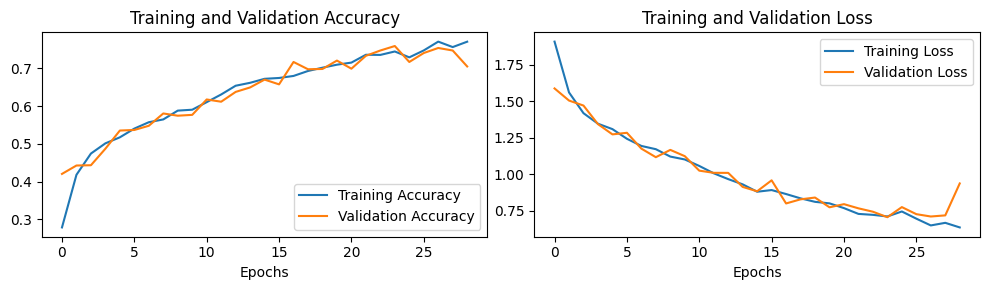

In [60]:
plot_curve(history, len(history.epoch))

#### Analysis of results. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### Inference:

1) The model trained using additional 500 images per class showcases optimal performance with little signs of underfitting or overfitting.

2) The use of class rebalancing has improved the model's performance across both training and validation datasets.

3) For 29(using early stopping) epochs, this model attains an training accuracy of ~77% and ~76% validation accuracy.

4) The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.

5) The addition of batch normalization for either with or without image augmentation failed to enhance both training and validation accuracy

#### Further Improvements:
     1) The final augmentated model shows very small signs of underfitting.
     2) To reduce it we can try following approaches:
        - increase CNN layers or Dense layers along with increased dropout rate to curb potential overfitting
        - augment more than 500 images per class
        - after additional augmentation try with more epochs(like 100) with early stopping to get the most optimal model
        - rather than training a CNN from scratch use transfer learning techniques with base model like resnet, vgg19